# Products by departments

In [ ]:
import os
import shutil
import goes2go as g2g
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
# Define the start and end datetimes
start_date = datetime(2021, 1, 1)
end_date = datetime(2023, 1, 1)
num_days = (end_date - start_date).days
date_list = [start_date + timedelta(days=i) for i in range(num_days + 1)]
ImagesPath = "./GOESimages/"
product_list = { # ABI Products
"ABI-L2-ACMF": "Clear Sky Mask",
"ABI-L2-ACHAF": "Cloud Top Height",
"ABI-L2-ACHTF": "Cloud Top Temperature",
"ABI-L2-LSTF": "Land Surface Temperature",
}
# display(product_list)
from myfunctions.GOESfunctions import definingColormaps
colormaps = definingColormaps(False)
import geopandas as gpd
gdf_peru_land = gpd.read_file("./Boundaries/PER_adm/PER_adm1.shp")
department_names = sorted(gdf_peru_land['NAME_1'].tolist())
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

for product in list(product_list):
    os.makedirs(os.path.join(ImagesPath,"Departments",product), exist_ok=True)
    G = g2g.GOES(satellite=16, product=product)
    product_cmap = colormaps[product]
    for date_index, date in enumerate(date_list[:-1]):
        dsl = G.timerange(start=date_list[date_index], end=date_list[date_index+1], save_dir=ImagesPath, return_as = "filelist");
        # display.clear_output(wait=True)
        file_list = list(dsl['file'])
        for selected_file in file_list:
            # print("Working with file: ", selected_file)
            FullFilePath = os.path.join(ImagesPath,selected_file)
            rds = xr.open_dataset(FullFilePath, engine='rasterio')
            rds.close()
            data_re = rds.rio.reproject("EPSG:4326")
            input_datetime = datetime.strptime(data_re.attrs['date_created'], '%Y-%m-%dT%H:%M:%S.%fZ')
            output_date_string = input_datetime.strftime('%Y-%m-%d %H:%M:%S %Z')
            day, month, year = output_date_string[8:10], output_date_string[5:7], output_date_string[:4]
            hour, minute, seconds = output_date_string[11:13], output_date_string[14:16], output_date_string[17:20]
            varname = list(data_re.data_vars.keys())[0]
            data = data_re[varname].isel(band=0)
            for department in department_names:
                outputs_directory = os.path.join(ImagesPath,"Departments",product, department)
                ImageName = '_'.join([product,department,year,month,day,hour,minute])
                FullImagePath = os.path.join(outputs_directory,ImageName+'.tif')
                os.makedirs(outputs_directory, exist_ok=True)
                polygon = gdf_peru_land[gdf_peru_land['NAME_1']==department]['geometry']
                data_clip = data.rio.clip(polygon)
                
                # fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))
                # im = ax.contourf(data_clip.x,data_clip.y,data_clip.values,5,cmap=product_cmap)
                # plt.colorbar(im, label = data.attrs['long_name']+' ['+data.attrs['units']+']')
                # ax.set(title = 'Department: '+ department,
                    #    xlabel = "Longitude",
                    #    ylabel = "Latitude")
                # ax.add_geometries(polygon, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black')
                # ax.gridlines(draw_labels=True,lw=0.75,color='k',alpha=0.7,ls='--')
                
                # plt.savefig(FullImagePath,dpi=300,bbox_inches='tight')
                # plt.show()
                data_array = xr.DataArray(data_clip.values, coords=[data_clip.y, data_clip.x], dims=['latitude', 'longitude'])
                data_array.rio.write_crs("EPSG:4326")
                data_array.rio.to_raster(FullImagePath)
                
        print("Product "+product+"for "+date_list[date_index].strftime('%B')+" month processed.")
        parent_directory = os.path.join(ImagesPath,'noaa-goes16',product,str(date.year))
        subdirectories = [d for d in os.listdir(parent_directory) if os.path.isdir(os.path.join(parent_directory, d))]
        date.year
        for subdirectory in subdirectories:
            subdirectory_path = os.path.join(parent_directory, subdirectory)
            try:
                shutil.rmtree(subdirectory_path)
                print(f"Directory '{subdirectory_path}' and its contents successfully removed.")
            except OSError as e:
                print(f"Error deleting '{subdirectory_path}': {e}")


# Products in a time range

In [1]:
#==================== We set product parameters to download ====================
import os
import goes2go as g2g
destination_path = '.\\GOESimages\\'
bucket = 'noaa-goes16'
product_list = { # ABI Products
# "ABI-L2-ACMF": "Clear Sky Mask",
# "ABI-L2-ACHAF": "Cloud Top Height",
# "ABI-L2-ACTPF": "Cloud Top Phase",
# "ABI-L2-ACHTF": "Cloud Top Temperature",
# "ABI-L2-LSTF": "Land Surface Temperature",
"ABI-L2-RRQPEF": "Rainfall rate",
# "ABI-L2-DSRF": "Downward Shortwave Radiation",
# "ABI-L2-DMWVF": "Derived Motion Winds - Vapor"
}
#==================== Setting up time reference variables ====================
from datetime import datetime, timedelta, timezone
import pytz
utc = pytz.timezone('UTC') # UTC timezone
utcm5 = pytz.timezone('America/Lima') # UTC-5 timezone
initial_date = utc.localize(datetime(2023,9,13,17)).astimezone(utc).replace(tzinfo=None)
final_date = utc.localize(datetime(2023,9,13,18)).astimezone(utc).replace(tzinfo=None)
from IPython.display import display, clear_output
# Set the time interval for clearing the output
time_interval = timedelta(hours=1)
start_time = datetime.now(utcm5)
from GOESutils.GOESplots import GeoColorPlot, ProductData, ProductPlot

for product in list(product_list):
    CurrentTime = datetime.now(utcm5)
    CurrentTime_str = CurrentTime.strftime('%Y-%m-%d %H:%M:%S %Z')
    print("============================================================")
    print("Current time is: {}".format(CurrentTime_str))
    prodFileList = g2g.data.goes_timerange(initial_date, final_date, satellite=bucket, product=product, domain='F', download=True, save_dir=destination_path, return_as='filelist')
    print(f"There are {prodFileList.shape[0]} to be processed")
    for f in list(prodFileList['file']): 
        print("Working with file: {}".format(os.path.basename(f)))                
        FullFilePath = os.path.join(destination_path,f)
        data_re, ProductParams = ProductData(FullFilePath, product)
        
        if os.path.exists(ProductParams["FullImagePath"]):
            print("Image '{}' already exists in '{}'".format(ProductParams["ImageName"],ProductParams["ImagePath"]))
        else:
            file_datetime = ProductParams["ImgTime"].astimezone(utc)
            fig, ax = GeoColorPlot(destination_path, mode="timerange", file_datetime=file_datetime, toSave=True, toDisplay=False)
            if (not os.path.exists(ProductParams["ImagePath"])):
                print(f"Directory for product {product} does not exist. Creating new one...") 
                os.makedirs(ProductParams["ImagePath"])
            print(f"Image for file {os.path.basename(f)} not found, creating one...")
            figProd = ProductPlot(data_re, product, ax, ProductParams, toSave=True)
            display(figProd)
            print("Image '{}' saved in '{}'".format(ProductParams["ImageName"], ProductParams["ImagePath"]))
    print("All the files have been processed.")
    
# Check if it's time to clear the output
CurrentTime = datetime.now(utcm5)
minute, seconds = CurrentTime.minute, CurrentTime.second
elapsed_time = CurrentTime - start_time
if elapsed_time >= time_interval:
    # Clear the output
    clear_output(wait=True)
    # Reset the start time
    start_time = datetime.now()

SyntaxError: invalid syntax (GOESplots.py, line 118)

# Products in real time

/home/german/miniconda3/envs/satimg/lib/python3.11/site-packages/toolbox/cartopy_tools_OLD.py:37: UserWarning: Migrate to new `cartopy_tools` for latest updates and features.
  warnings.warn("Migrate to new `cartopy_tools` for latest updates and features.")
/home/german/miniconda3/envs/satimg/lib/python3.11/site-packages/toolbox/cartopy_tools_OLD.py:241: AccessorRegistrationWarning: registration of accessor <class 'toolbox.cartopy_tools_OLD.xr_to_cartopy'> under name 'xmap' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  @xr.register_dataset_accessor("xmap")


Current time is: 2023-10-17 15:19:57 -05
Verifying internet connection...
 👮🏻‍♂️ File already exists. Do not overwrite: GOESimages/noaa-goes16/ABI-L2-MCMIPF/2023/290/20/OR_ABI-L2-MCMIPF-M6_G16_s20232902000204_e20232902009512_c20232902009595.nc
📦 Finished downloading [1] files to [GOESimages/noaa-goes16/ABI-L2-MCMIPF].
Getting latest available
Reading file OR_ABI-L2-MCMIPF-M6_G16_s20232902000204_e20232902009512_c20232902009595.nc as geocolor image.
Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...
Verifying internet connection...
 👮🏻‍♂️ File already exists. Do not overwrite: GOESimages/noaa-goes16/ABI-L2-RRQPEF/2023/290/20/OR_ABI-L2-RRQPEF-M6_G16_s20232902000204_e20232902009512_c20232902010002.nc
📦 Finished downloading [1] files to [GOESimages/noaa-goes16/ABI-L2-RRQPEF].
Getting latest available
Working with file: OR_ABI-L2-RRQPEF-M6_G16_s20232902000204_e20232902009512_c20232902010002.nc
No interpolation performed
Image 'goes16_RR

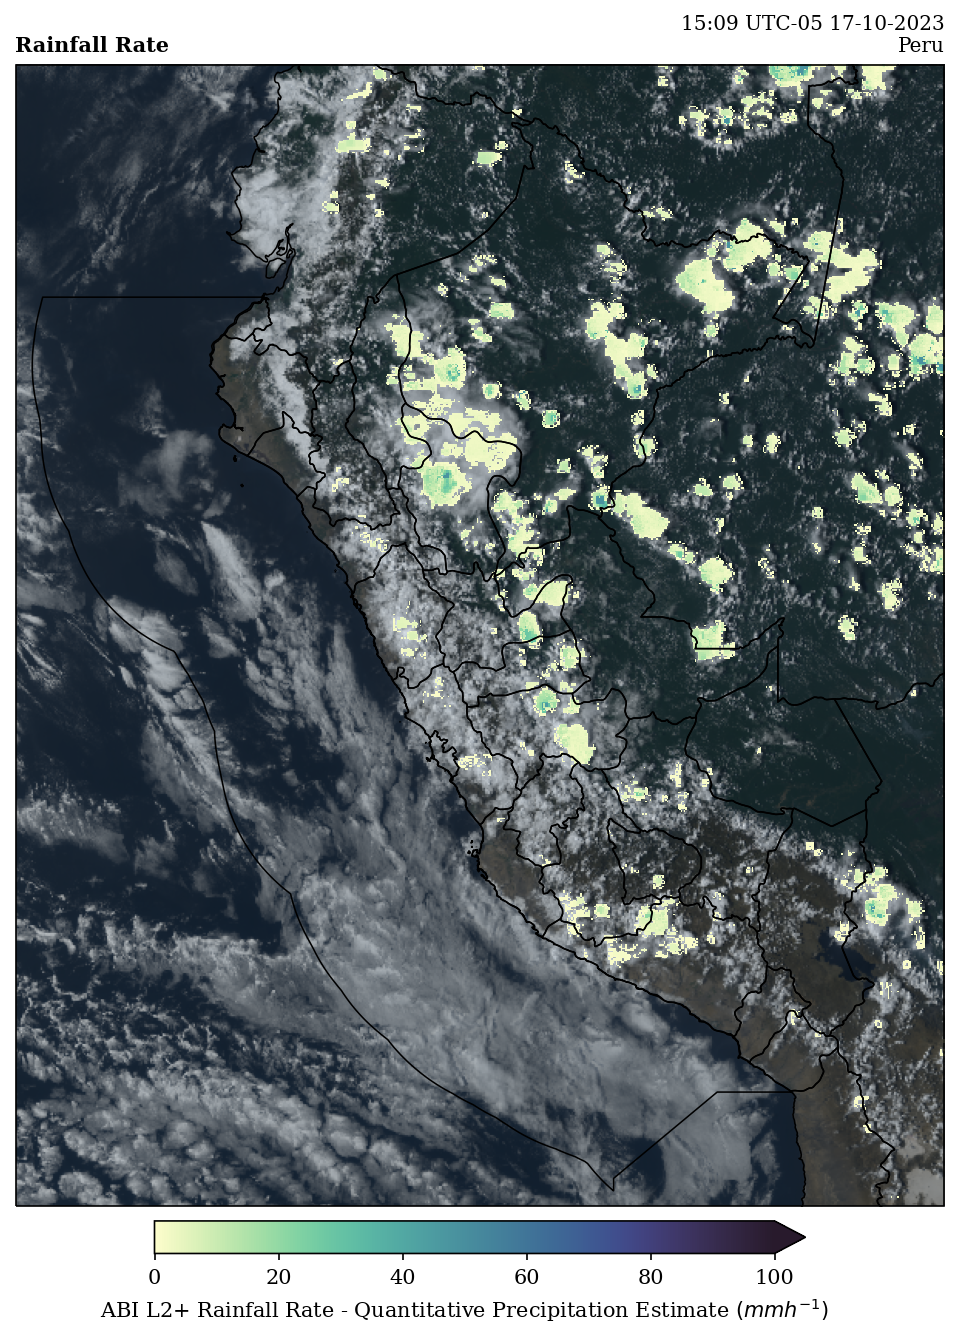

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


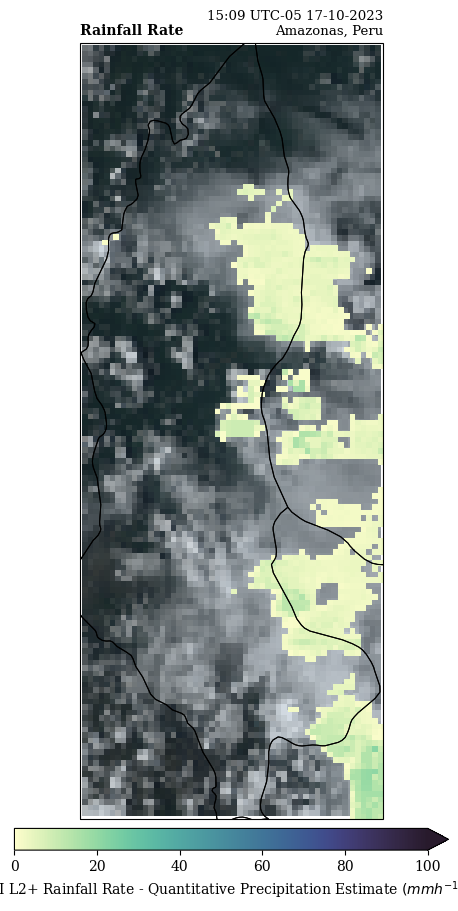

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


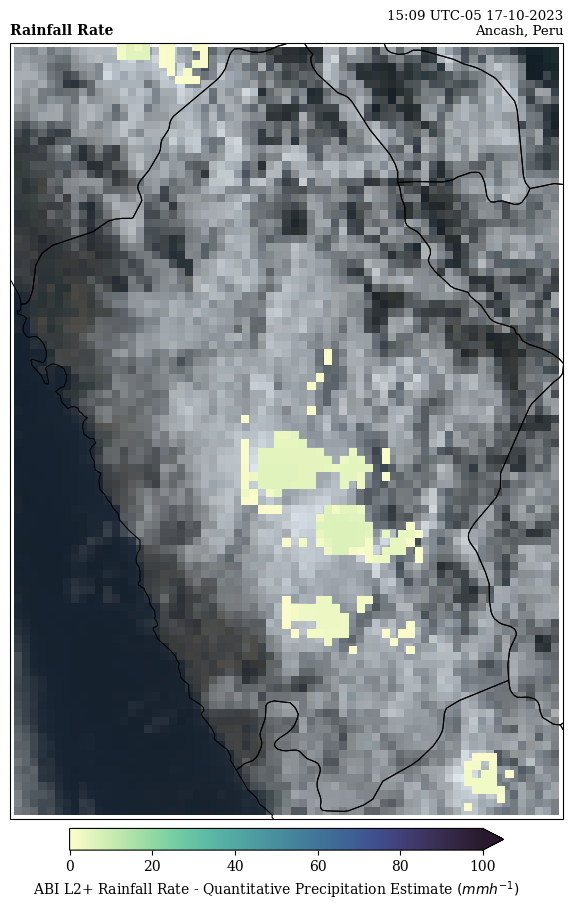

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


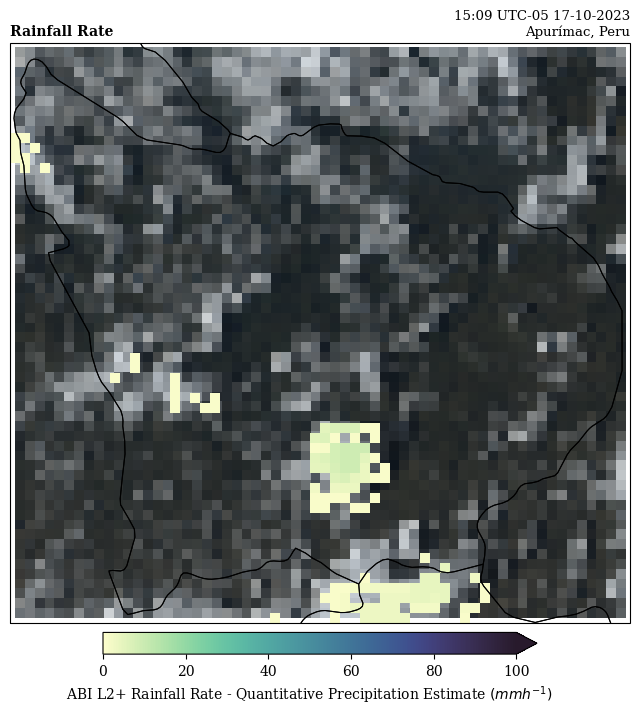

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


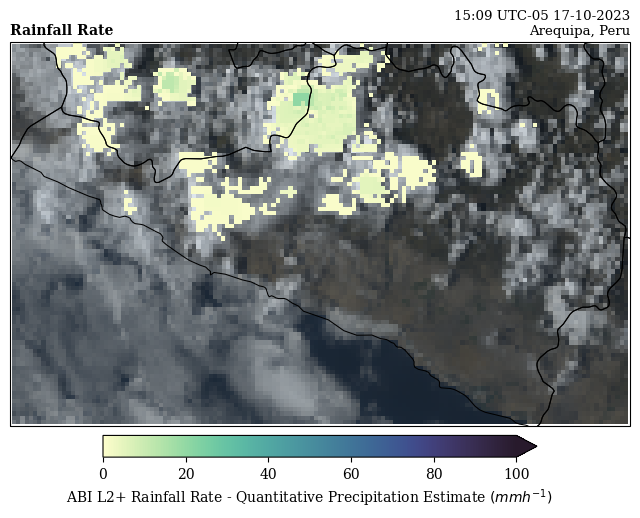

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


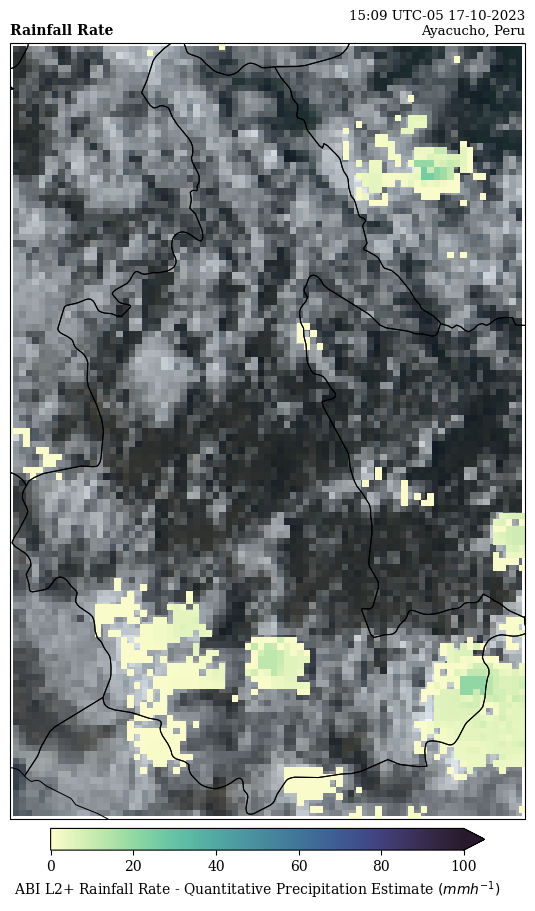

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


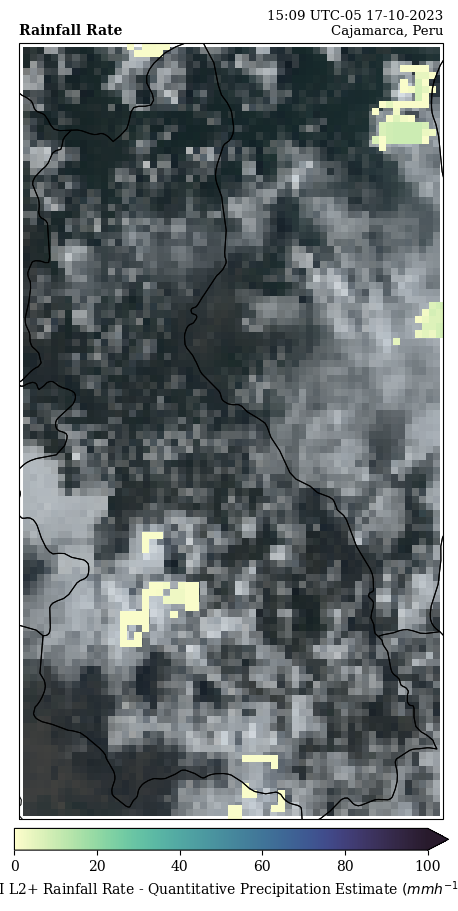

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


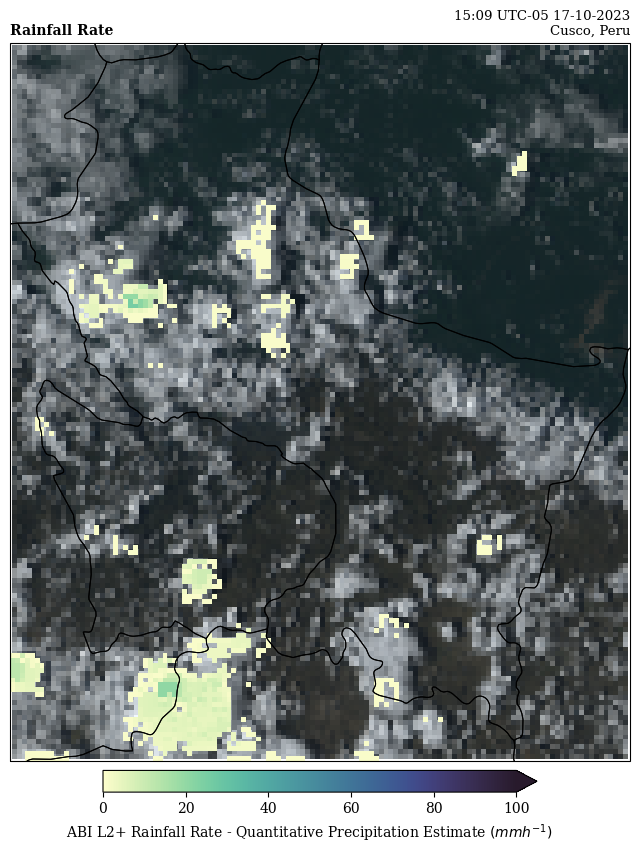

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


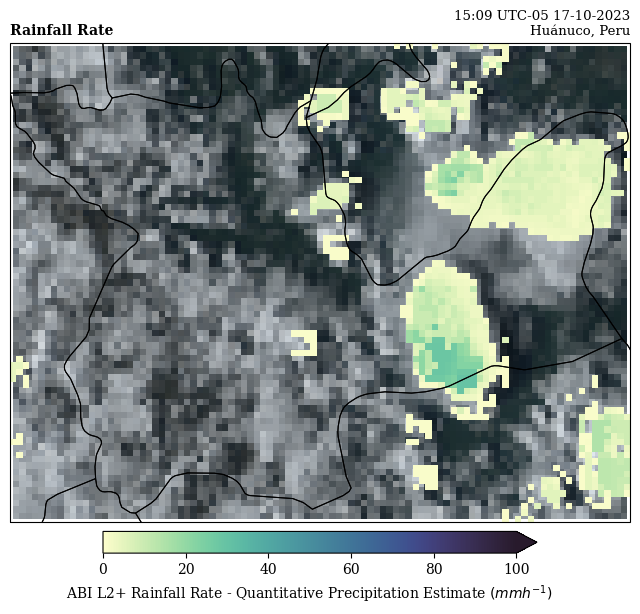

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


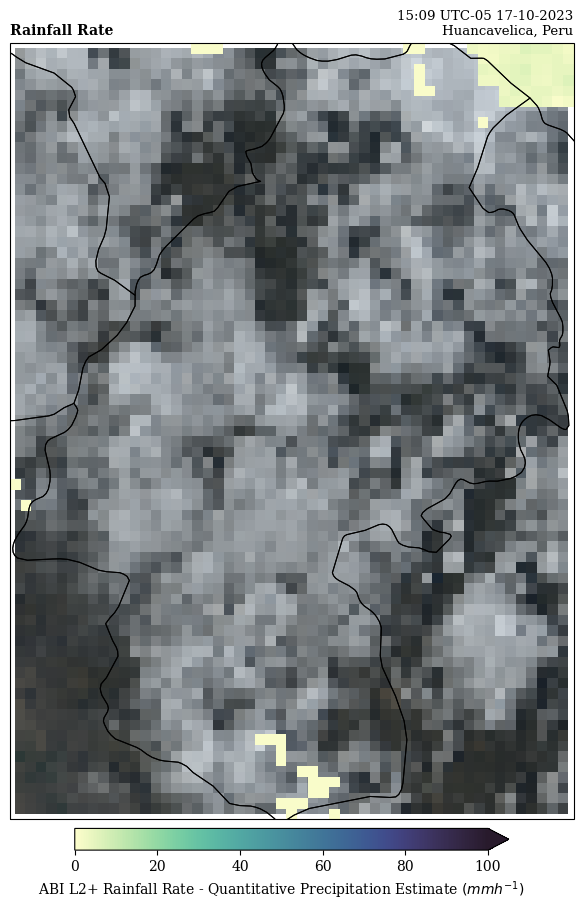

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


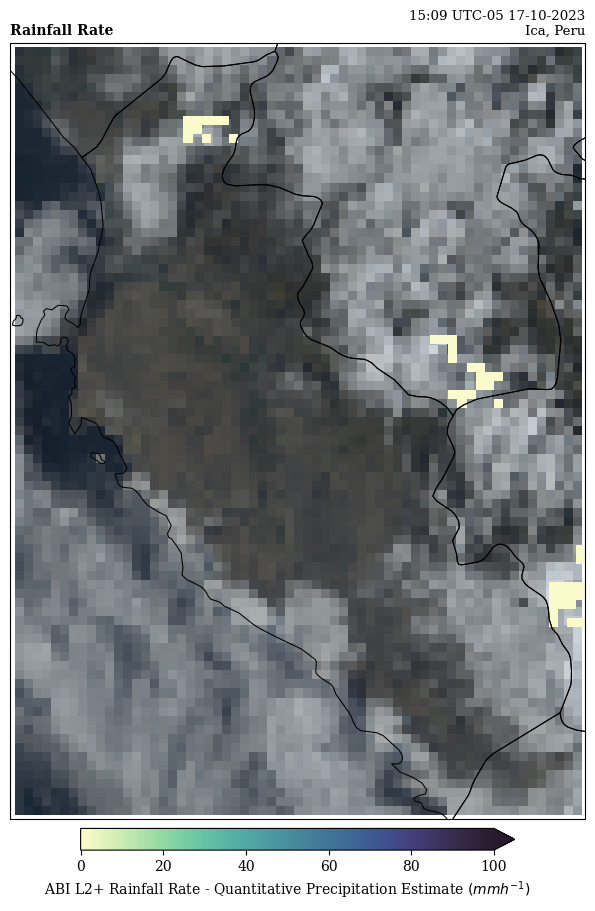

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


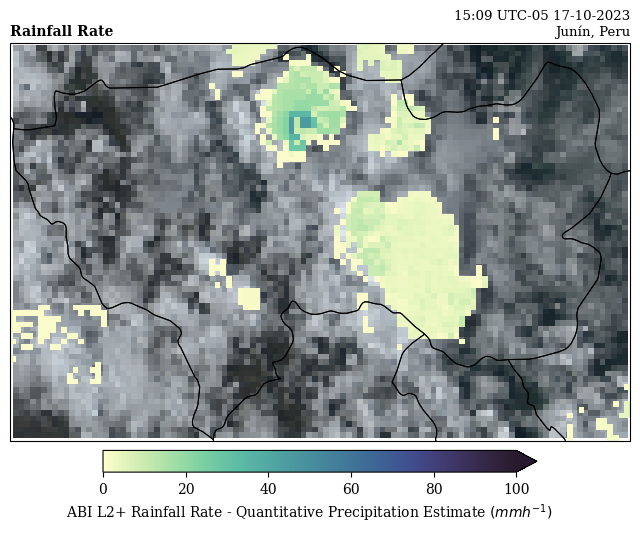

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


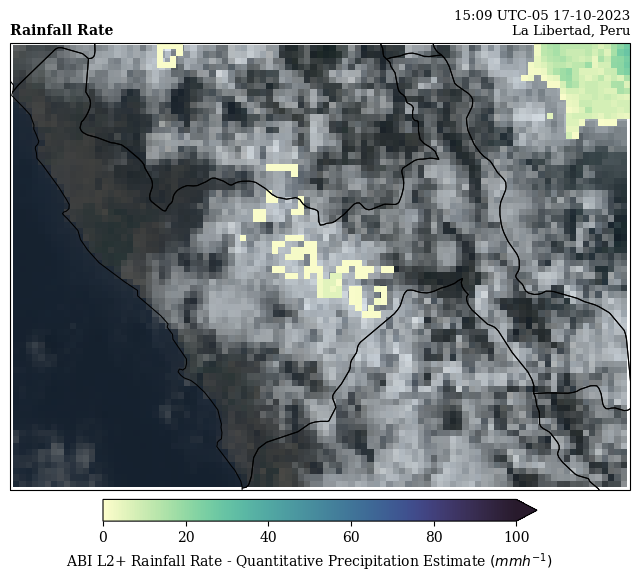

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


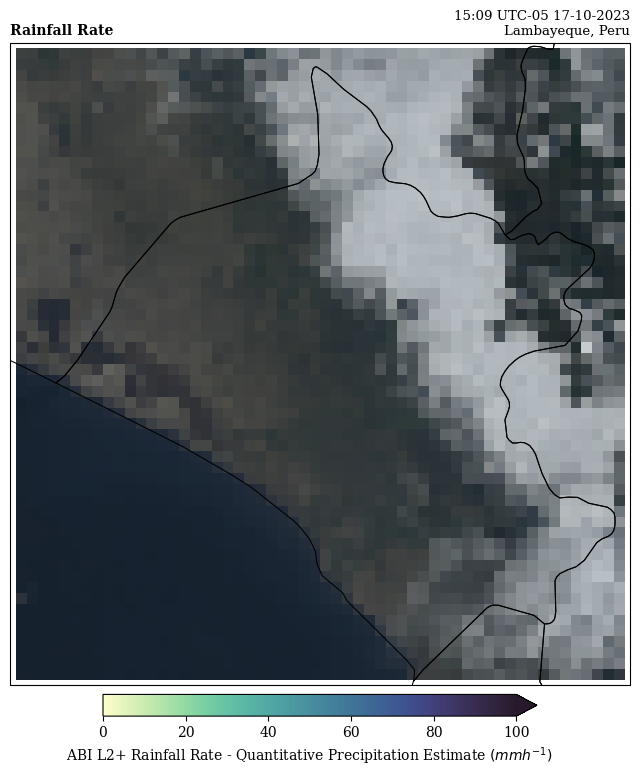

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


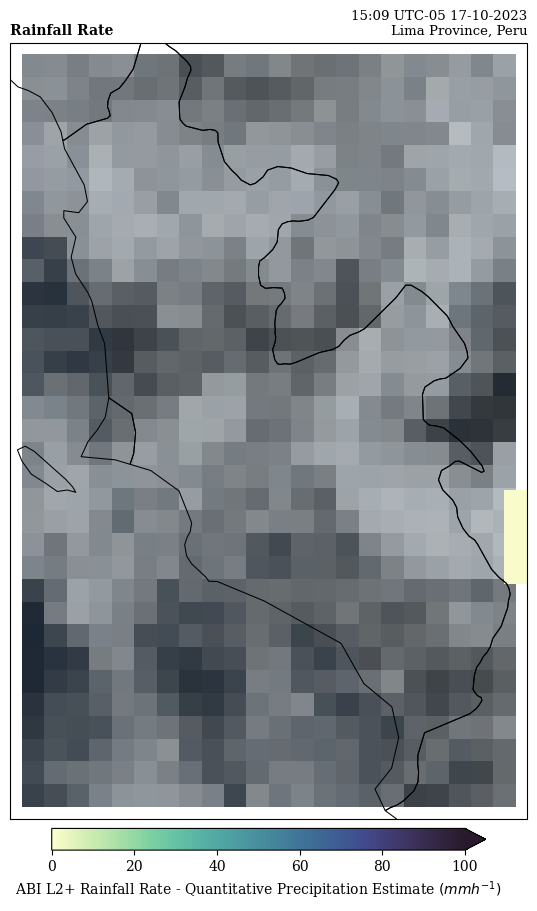

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


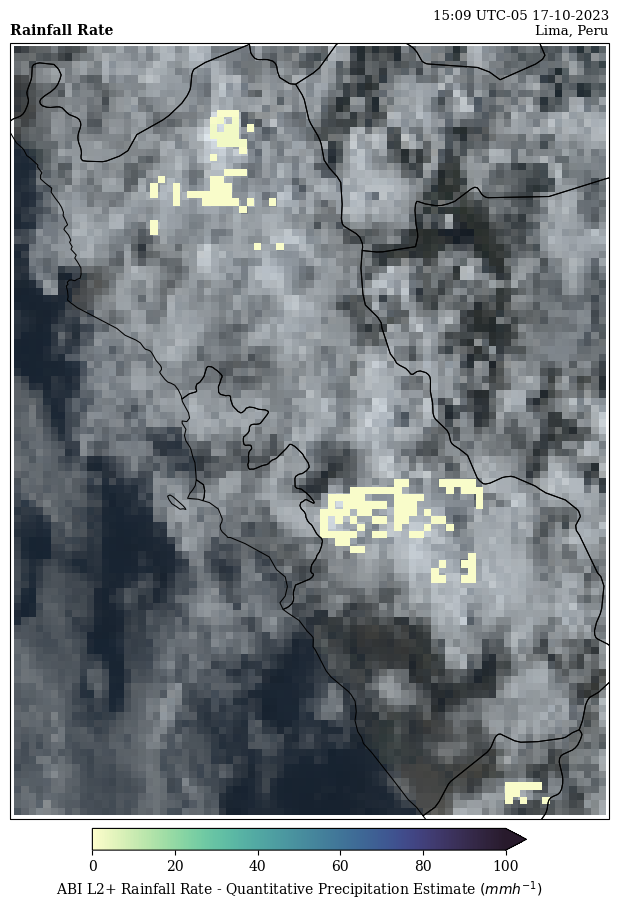

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


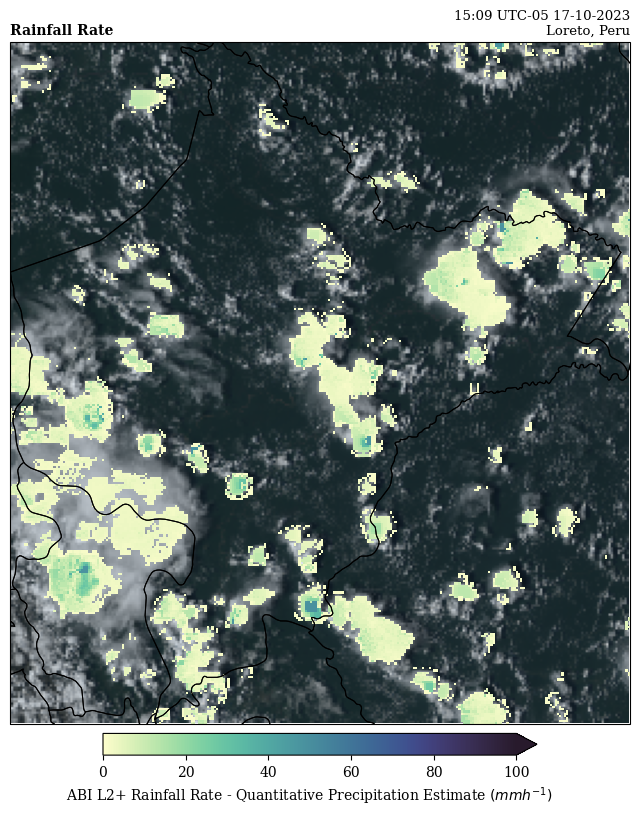

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


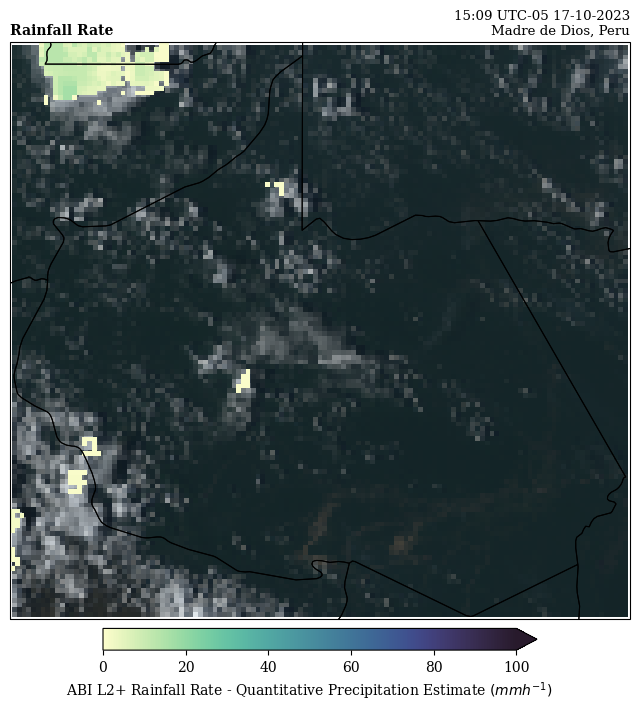

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


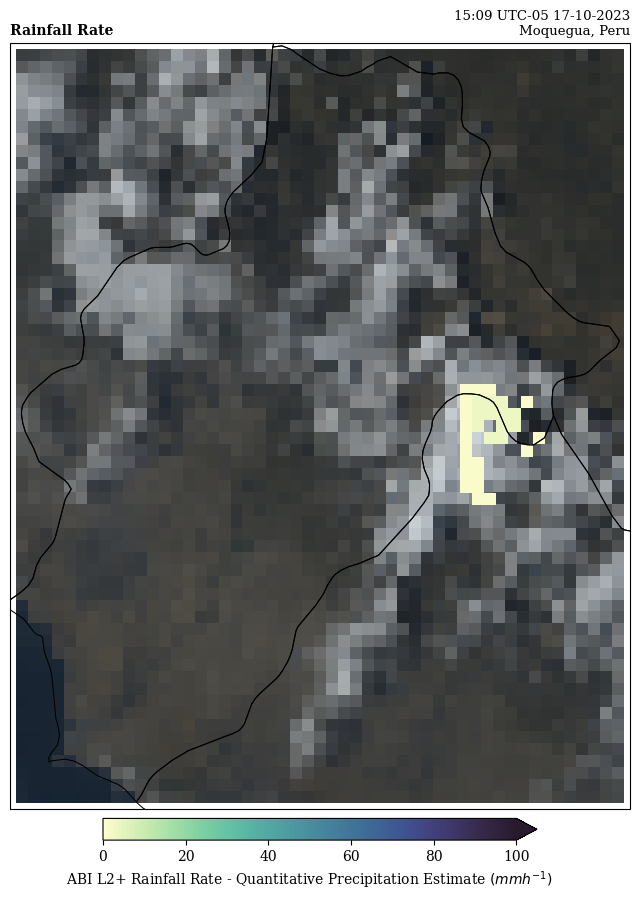

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


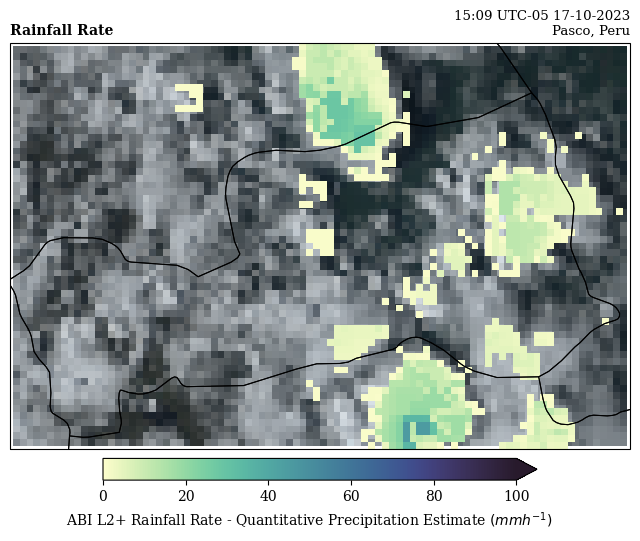

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


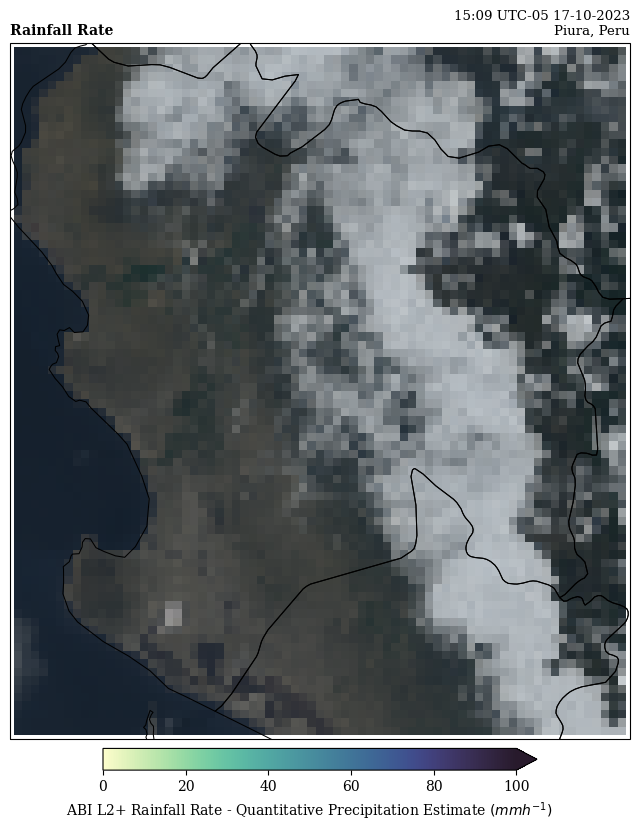

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


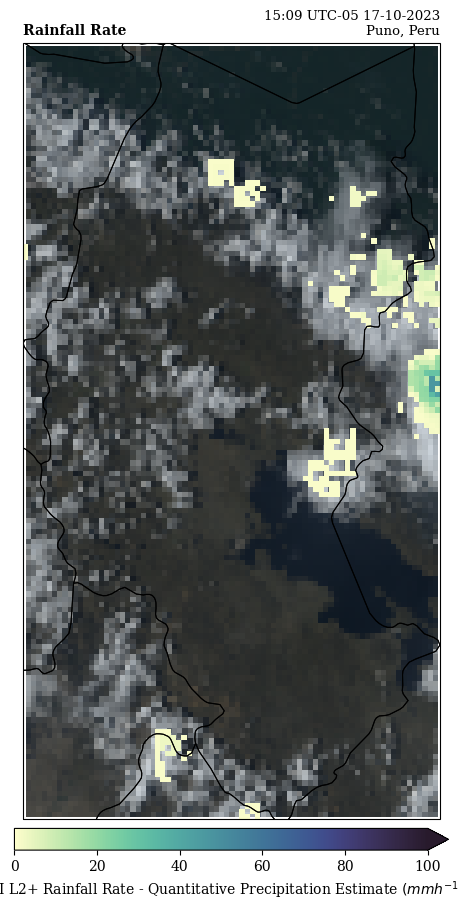

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


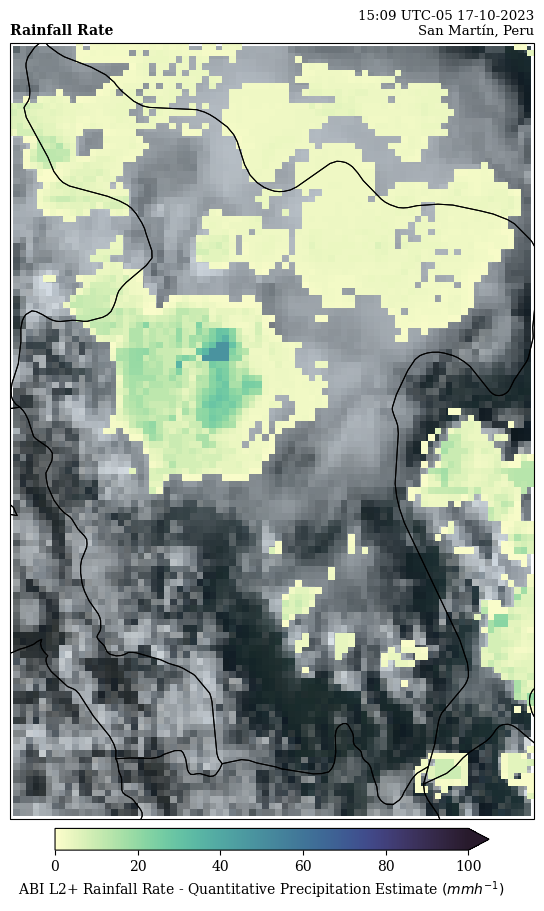

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


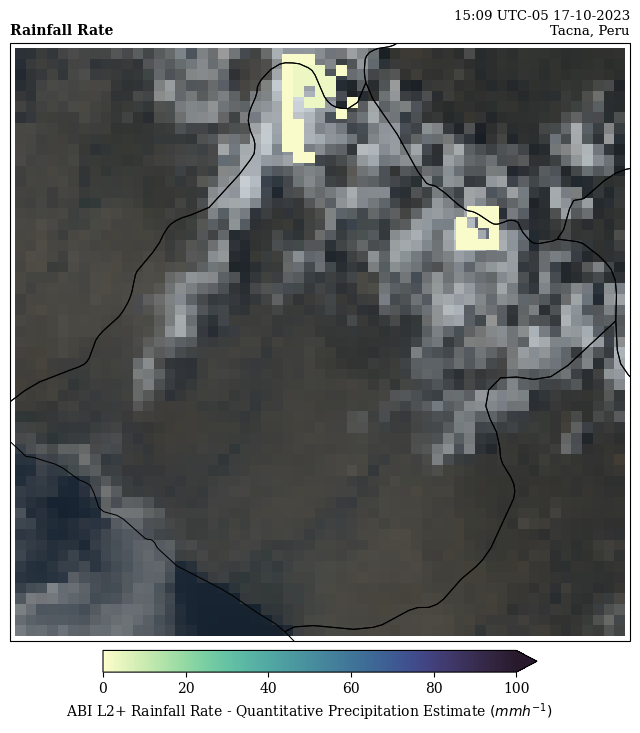

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


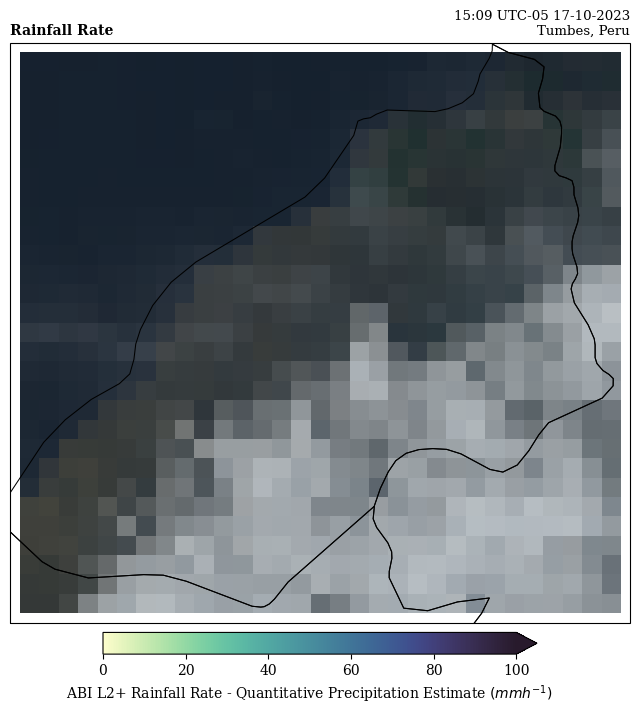

Plotting geocolor image at 2023-10-17 15:09:51.200000-05:00.
It is daytime! Plotting NaturalColor image...


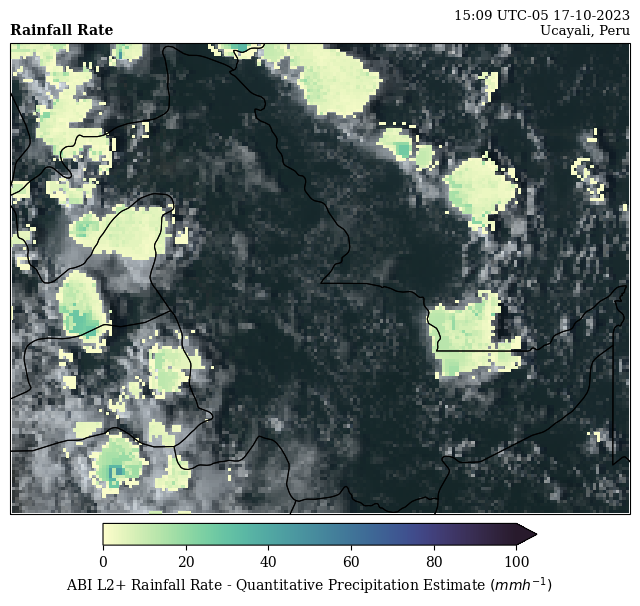

All the files have been processed.
Waiting 10 minutes for the next file upload


In [3]:
#==================== We set product parameters to download ====================
import goes2go as g2g
destination_path = './GOESimages/'
bucket = 'noaa-goes16'
product_list = { # ABI Products
# "ABI-L2-ACMF": "Clear Sky  Mask",
# "ABI-L2-ACHAF": "Cloud Top Height",
# "ABI-L2-ACTPF": "Cloud Top Phase",
# "ABI-L2-ACHTF": "Cloud Top Temperature",
# "ABI-L2-LSTF": "Land Surface Temperature",
"ABI-L2-RRQPEF": "Rainfall rate",
# "ABI-L2-DSRF": "Downward Shortwave Radiation",
# "ABI-L2-DMWVF": "Derived Motion Winds - Vapor",
# "ABI-L2-TPWF": "Total Precipitable Water",
}
#==================== Setting up time reference variables ====================
from datetime import datetime, timedelta, timezone
import os, pytz, time, requests
utc = pytz.timezone('UTC') # UTC timezone
utcm5 = pytz.timezone('America/Lima') # UTC-5 timezone
initial_date = datetime(2023,9,1)
final_date = datetime.now()
from IPython.display import display, Image, clear_output
# Set the time interval for clearing the output
time_interval = timedelta(minutes=30)
start_time = datetime.now(utcm5)
import GOESutils.GOESplots as gplt
import GOESutils.DataBaseUtils as dbu
import importlib, sys
importlib.reload(sys.modules['GOESutils.GOESplots'])
import GOESutils.GOESplots as gplt

import numpy as np
import matplotlib.pyplot as plt

while True:
    CurrentTime = datetime.now(utcm5)
    CurrentTime_str = CurrentTime.strftime('%Y-%m-%d %H:%M:%S %Z')
    print("============================================================")
    print("Current time is: {}".format(CurrentTime_str))
    RGBdata, GeoColorParams = gplt.GeoColorData(destination_path)
    figGeo, axGeo = gplt.GeoColorPlot(RGBdata, GeoColorParams, toSave=True, toDisplay=False, toUpload=False, dpi=150)

    for product in list(product_list):
        internet = False
        while not internet: # Check for internet connection to download products
            print("Verifying internet connection...")
            try: # In case there is internet connection
                res = requests.get("https://www.google.com/")
                if res.status_code == 200:
                    try: 
                        prodFileList = g2g.data.goes_latest(satellite=bucket, product=product, domain='F', download=True, save_dir=destination_path, return_as='filelist')
                        # prodFileList = g2g.data.goes_nearesttime(datetime.now(utc).replace(tzinfo=None) - timedelta(days=1) + timedelta(hours=5), satellite=bucket, product=product, domain='F', download=True, save_dir=destination_path, return_as='filelist')
                        print("Getting latest available")
                    except ValueError:
                        try:
                            CurrentTime = utc.localize(datetime.now()).replace(tzinfo=None)
                            prodFileList = g2g.data.goes_nearesttime(CurrentTime, satellite=bucket, product=product, domain='F', download=True, save_dir=destination_path, return_as='filelist')
                            print("Getting nearest available")
                        except ValueError:
                            CurrentTime = utc.localize(datetime.now()).replace(tzinfo=None) - timedelta(hours=1)
                            prodFileList = g2g.data.goes_nearesttime(CurrentTime, satellite=bucket, product=product, domain='F', download=True, save_dir=destination_path, return_as='filelist')
                            print("Getting nearest available 1 hour before")
                internet = True
            except Exception as e: # Waiting for internet connection
                print(f"Internet connection lost..{e}")
                internet = False
                print(f"Waiting for internet connection.")
                time.sleep(30)
            time.sleep(1)
        # old_files = os.listdir(ImgPath)
        # old_png_files = set([file for file in old_files if file.endswith('.png')])
        # are_there_old_filenames = (len(old_png_files) > 0)
        
        for f in list(prodFileList['file']): # Reading each file downloaded
            print("Working with file: {}".format(os.path.basename(f)))                
            FullFilePath = os.path.join(destination_path,f)
            data_re, ProductParams = gplt.ProductData(FullFilePath, product, n=4)
            if os.path.exists(ProductParams["FullImagePath"]): # If png image exists, it is shown
                print("Image '{}' already exists in '{}'".format(ProductParams["ImageName"],ProductParams["ImagePath"]))
                display(Image(filename=ProductParams["FullImagePath"], width=640))
            else: # Creating png image
                if (not os.path.exists(ProductParams["ImagePath"])):
                    print(f"Directory for product {product} does not exist. Creating new one...") 
                    os.makedirs(ProductParams["ImagePath"])
                print(f"Image for file {os.path.basename(f)} not found, creating one...")
                figProd = gplt.ProductPlot(data_re, product, axGeo, ProductParams, toSave=True, toDisplay=True, toUpload=False, dpi=150)

        gplt.DepartmentPlot(gplt.departments, product, RGBdata, GeoColorParams, data_re, ProductParams, toSave=True, toDisplay=True, toUpload=False)
            
        print("All the files have been processed.")
        
    # Check if it's time to clear the output
    try:
        CurrentTime = datetime.now(utcm5)
        hour, minute, seconds = CurrentTime.hour, CurrentTime.minute, CurrentTime.second
        elapsed_time = CurrentTime - start_time
        if elapsed_time >= time_interval:
            # Clear the output
            clear_output(wait=True)
            # Reset the start time
            start_time = datetime.now(utcm5)
        if (elapsed_time >= timedelta(hours=3)) or (hour==23 and minute>30):
            for product in list(product_list):
                dbu.eliminar(product.split("-")[-1][:-1])
            
        total_remaining_seconds = (10 - (int(minute) % 10)) * 60 - int(seconds)
        remaining_minutes = total_remaining_seconds // 60
        print("Waiting {} minutes for the next file upload".format(remaining_minutes + 1))
        time.sleep((remaining_minutes+1)*60)
    except Exception as e:
        print("Elapsed time attempting failed.")

In [25]:
polygon_dep = gdf_peru_land[gdf_peru_land['NAME_1'] == dep].geometry
data_dep = data_dep.rio.write_crs(data_dep.goes_imager_projection.crs_wkt)
data_dep = data_dep.rio.clip(polygon_dep)

In [79]:
# ACM reports
total_val = data_dep.count().values
clear_sky_count = np.count_nonzero((data_dep.values == 0) | (data_dep.values == 1))
clear_sky_percent = clear_sky_count/total_val*100
cloudy_sky_count = np.count_nonzero((data_dep.values == 2) | (data_dep.values == 3))
cloudy_sky_percent = cloudy_sky_count/total_val*100

print(f"Departamento {dep}: {cloudy_sky_percent:.1f}% nublado, {clear_sky_percent:.1f}% despejado")

Departamento Loreto: 18.7% nublado, 81.3% despejado


In [14]:
from GOESutils.MyUtils import interval_categorizer
# RRQPEF
# Light Rain: 0.1 - 2.0 mm/hour
# Moderate Rain: 2.1 - 10.0 mm/hour
# Heavy Rain: 10.1 - 50.0 mm/hour
# Very Heavy Rain: 50.1 - 100.0 mm/hour
# Extreme Rain: > 100.0 mm/hour
data_values = data_dep.values
thresholds = [0, 0.1, 2.0, 10.0, 50.0, 100.0]
category_labels = ["No rain", "Light Rain", "Moderate Rain", "Heavy Rain", "Very Heavy Rain", "Extreme Rain"]
rainfall_categories = interval_categorizer(data_values, thresholds, category_labels, lower_endpoint=0)

Intervals endpoints and midpoints for category labels: [  0.    0.1   2.   10.   50.  100.    inf]
1. No rain: 0.0 <= data < 0.1
2. Light Rain: 0.1 <= data < 2.0
3. Moderate Rain: 2.0 <= data < 10.0
4. Heavy Rain: 10.0 <= data < 50.0
5. Very Heavy Rain: 50.0 <= data < 100.0
6. Extreme Rain: 100.0 <= data < inf


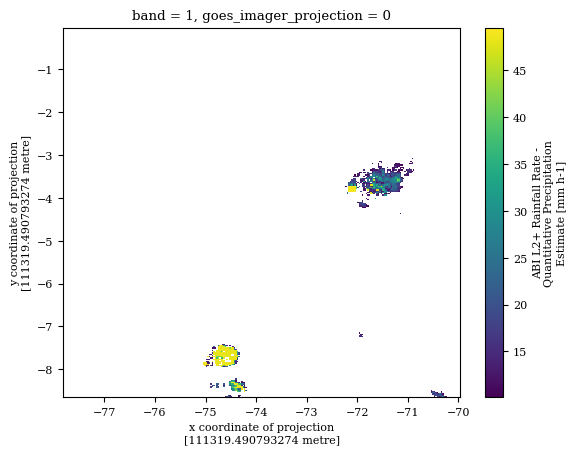

In [16]:
data_dep.where(rainfall_categories[category_labels[3]]).plot()